# Description

This project involves predicting customer sales on an e-commerce platform by gathering data using Google Analytics 4.

The input data comes from BigQuery, thanks to the integration between GTM, GA4, and BigQuery. The techniques implemented include EDA, feature engineering, feature selection, and XGBoost classification.

The main goal is to extract daily sales propensity for customers and create a dashboard to visualize the results

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uprofit-googleanalytics/customer_navigation.csv


In [2]:
#import operational packages
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
seed = 42

# Read csv

In [3]:
df = pd.read_csv("/kaggle/input/uprofit-googleanalytics/customer_navigation.csv")

# EDA (Exploratory Data Analysis)

# 1. Data Inspection

## First view of the data

In [4]:
#Checking the data for the first time
df.head(10)

,user_id,event_datetime,visitStartTime,visitSEndTime,session_number,device_operating_system,cant_events,continent,group_source_medium,price,device_category,session_start,page_view,user_engagement,scroll,login,click,begin_checkout,add_payment_info,purchase
0,1.656169e+09,2024-06-28,2024-06-28 16:58:36.905128 UTC,2024-06-28 17:00:09.007845 UTC,1,NaN,2,Africa,Organic Search,NaN,desktop,0,1,0,1,0,0,0,0,0
1,9.435355e+08,2024-04-18,2024-04-19 02:47:29.404924 UTC,2024-04-19 02:47:29.404924 UTC,1,NaN,3,Europe,Referral,NaN,desktop,1,1,0,0,0,0,0,0,0
2,4.636929e+08,2024-02-10,2024-02-11 00:08:39.873807 UTC,2024-02-11 00:08:39.873807 UTC,1,NaN,3,Americas,Direct,NaN,desktop,1,1,0,0,0,0,0,0,0
3,8.104327e+08,2024-05-26,2024-05-26 20:25:30.48892 UTC,2024-05-26 20:25:30.48892 UTC,1,NaN,3,Europe,Referral,NaN,desktop,1,1,0,0,0,0,0,0,0
4,1.131114e+09,2024-02-11,2024-02-12 02:37:26.705679 UTC,2024-02-12 02:37:26.705679 UTC,1,NaN,3,Americas,Direct,NaN,desktop,1,1,0,0,0,0,0,0,0
5,5.698540e+07,2024-02-09,2024-02-09 06:39:44.395664 UTC,2024-02-09 06:39:44.395664 UTC,1,NaN,3,Europe,Direct,NaN,desktop,1,1,0,0,0,0,0,0,0
6,1.707864e+09,2024-02-24,2024-02-24 13:51:16.848973 UTC,2024-02-24 13:51:16.848973 UTC,1,NaN,3,Europe,Referral,NaN,desktop,1,1,0,0,0,0,0,0,0
7,1.129115e+09,2024-05-10,2024-05-10 16:04:56.318408 UTC,2024-05-10 16:04:56.318408 UTC,1,NaN,3,Americas,Direct,NaN,desktop,1,1,0,0,0,0,0,0,0
8,1.990876e+09,2024-04-05,2024-04-05 09:33:31.390871 UTC,2024-04-05 09:33:31.390871 UTC,1,NaN,3,Americas,Direct,NaN,desktop,1,1,0,0,0,0,0,0,0
9,1.222870e+09,2024-02-10,2024-02-11 01:24:56.621704 UTC,2024-02-11 01:24:56.621704 UTC,1,NaN,3,Europe,Direct,NaN,desktop,1,1,0,0,0,0,0,0,0


## Shape

In [5]:
#Checking dataframe size
df.shape

(682201, 20)

In [6]:
df.info()
# 7 string
# 13 numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682201 entries, 0 to 682200
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  682201 non-null  float64
 1   event_datetime           682201 non-null  object 
 2   visitStartTime           682201 non-null  object 
 3   visitSEndTime            682201 non-null  object 
 4   session_number           682201 non-null  int64  
 5   device_operating_system  682182 non-null  object 
 6   cant_events              682201 non-null  int64  
 7   continent                682201 non-null  object 
 8   group_source_medium      681656 non-null  object 
 9   price                    30230 non-null   float64
 10  device_category          682201 non-null  object 
 11  session_start            682201 non-null  int64  
 12  page_view                682201 non-null  int64  
 13  user_engagement          682201 non-null  int64  
 14  scro

## Percentage of sales

In [7]:
#Create a sale column where if price > 0 then it'll be 1 else 0
cant_sales = np.where(df['price']>0,1,0).sum()
total_sessions = df.shape[0]
total_unique_users = df['user_id'].nunique()
total_unique_users_purchase = df[df['price'] >0]['user_id'].nunique()

#Total unique users
print(f'Total unique user IDs: {total_unique_users}')

#Total unique users with purchase
print(f'Total unique user IDs with purchase: {total_unique_users_purchase}')

#% unique users wit purchase
print(f'The percentage of sales over the entire dataset is: {((total_unique_users_purchase / total_unique_users) * 100):.2f}%')

#Print total of session
print(f'The total of sessions from the beginning of 2024 are: {total_sessions}')

#Print total sales
print(f'The total of purchases from the beginning of 2024 are: {cant_sales}')

#Calculate % of sales on the full dataframe
print(f'The percentage of sales over the entire dataset is: {((cant_sales / total_sessions) * 100):.2f}%')

Total unique user IDs: 229838
Total unique user IDs with purchase: 13052
The percentage of sales over the entire dataset is: 5.68%
The total of sessions from the beginning of 2024 are: 682201
The total of purchases from the beginning of 2024 are: 30230
The percentage of sales over the entire dataset is: 4.43%


# 2. Data Cleaning and Data Type Conversion

## Handling missing values

In [8]:
#Add column sales, it indicates if the session end on a sale or not. it'll be the predicted column
#df['sales'] = (df['price'] > 0).astype(int)
df['price'] = df['price'].fillna(0).infer_objects(copy=False) # Replace NaN values by 0

In [9]:
#Add new column
df['has_purchase'] = df['purchase'].apply(lambda x: 1 if x > 0 else 0)

## Data type conversion

In [10]:
df['event_datetime'] = pd.to_datetime(df['event_datetime'], errors='coerce', utc=True)
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'], errors='coerce', utc=True)
df['visitSEndTime'] = pd.to_datetime(df['visitSEndTime'], errors='coerce', utc=True)

In [11]:
#transform user_id to string
df['user_id'] = df['user_id'].astype(str)

## Duplicates values

In [12]:
#Duplicates
df.shape[0] # 682201
df.drop_duplicates().shape[0] #682201
#Not duplicated values

682201

# 3. Data Inspection

## Categorical variables

Check distribution and behavior of categorical variables

### 1. device_operation_system

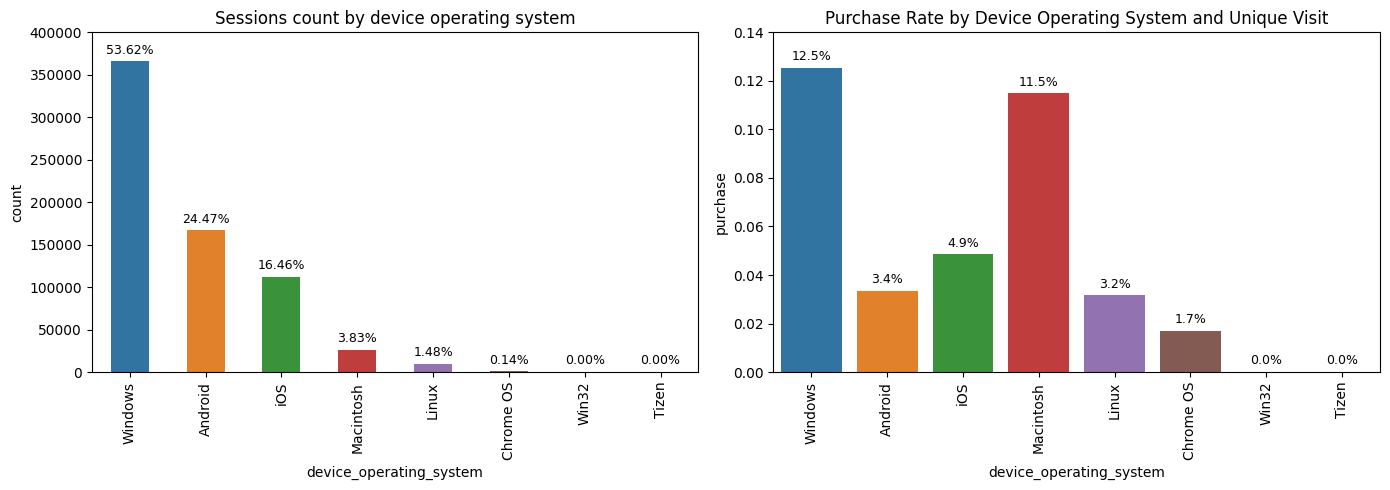

In [13]:
order_values = df['device_operating_system'].value_counts().index

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: countplot of device operating system, sorted by the same order as barplot
sns.countplot(df, x='device_operating_system', width=0.5, order=order_values, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Sessions count by device operating system')
ax1.set_ylim([0,400000])

# Add percentage labels on top of each bar in the second plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height / df.shape[0] * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=9, color='black', 
                xytext=(0, 8), textcoords='offset points')


# Create a grouped dataset with purchase rate, including 'unique_visit' for hue
df_grouped = df.groupby(['device_operating_system'])['purchase'].mean().reset_index()

# Second plot: barplot with purchase rates, sorted by the same order
sns.barplot(data=df_grouped, x='device_operating_system', y='purchase', order=order_values, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Purchase Rate by Device Operating System and Unique Visit')
ax2.set_ylim([0,0.14])

# Add percentage labels on top of each bar in the second plot
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height * 100:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=9, color='black', 
                xytext=(0, 8), textcoords='offset points')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

### 2. Device Category

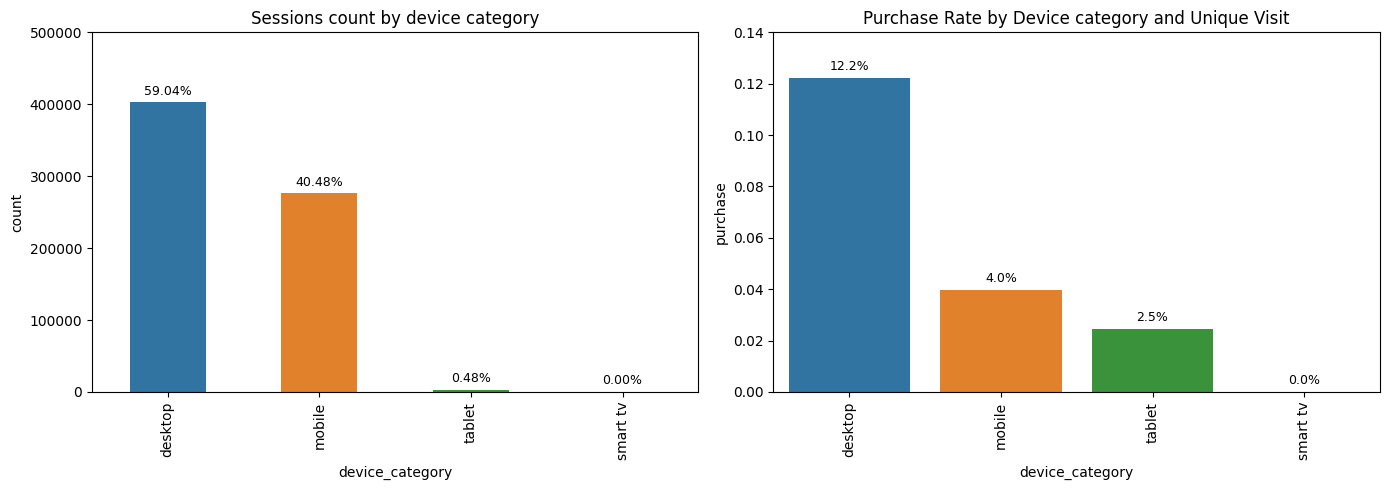

In [14]:
order_values = df['device_category'].value_counts().index

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: countplot of device operating system, sorted by the same order as barplot
sns.countplot(df, x='device_category', width=0.5, order=order_values, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Sessions count by device category')
ax1.set_ylim([0,500000])

# Add percentage labels on top of each bar in the second plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height / df.shape[0] * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=9, color='black', 
                xytext=(0, 8), textcoords='offset points')


# Create a grouped dataset with purchase rate, including 'unique_visit' for hue
df_grouped = df.groupby(['device_category'])['purchase'].mean().reset_index()

# Second plot: barplot with purchase rates, sorted by the same order
sns.barplot(data=df_grouped, x='device_category', y='purchase', order=order_values, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Purchase Rate by Device category and Unique Visit')
ax2.set_ylim([0,0.14])

# Add percentage labels on top of each bar in the second plot
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height * 100:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=9, color='black', 
                xytext=(0, 8), textcoords='offset points')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

### 3. Continent

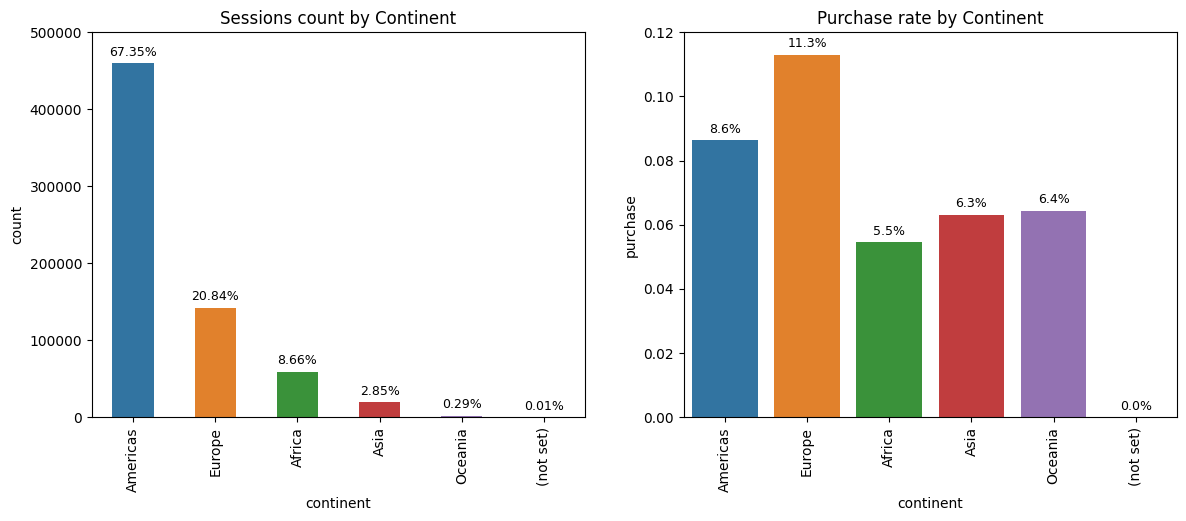

<Figure size 640x480 with 0 Axes>

In [15]:
order_columns = df['continent'].value_counts().index
fig = plt.figure(figsize = (14,5))

ax1 = fig.add_subplot(1,2,1)
sns.countplot(df, x = 'continent', width = 0.5, ax = ax1, order = order_columns)
ax1.set_title('Sessions count by Continent')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylim([0,500000])

# Add percentage labels on top of each bar in the second plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height / df.shape[0] * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=9, color='black', 
                xytext=(0, 8), textcoords='offset points')


ax2 = fig.add_subplot(1,2,2)
df_grouped = df.groupby('continent')['purchase'].mean().reset_index()
sns.barplot(df_grouped, x = 'continent', y= 'purchase', ax = ax2, order = order_columns)
ax2.set_title('Purchase rate by Continent')
ax2.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax2.set_ylim([0,0.12])

# Add percentage annotations
for p in ax2.patches:
    ax2.annotate(f'{p.get_height() * 100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                 textcoords='offset points')

plt.show()
plt.tight_layout()

### 4. group_source_medium

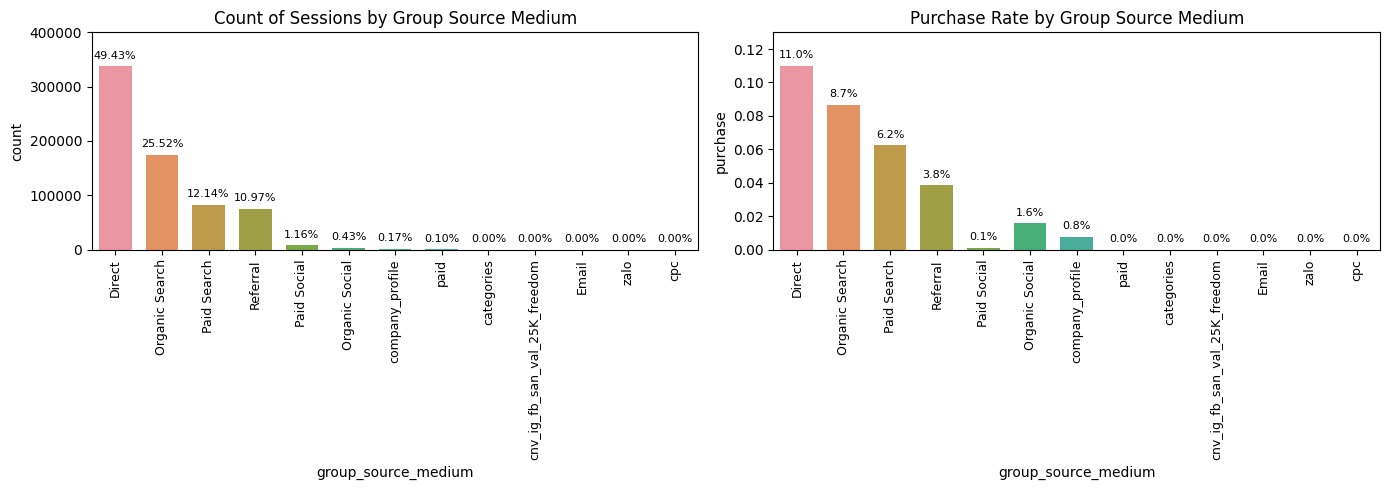

In [16]:
order_columns = df['group_source_medium'].value_counts().index

# Set up the figure
fig = plt.figure(figsize=(14, 5))

# First plot: countplot of group_source_medium
ax1 = fig.add_subplot(1, 2, 1)
sns.countplot(df, x='group_source_medium', ax=ax1, width=0.7, order=order_columns)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha='center', fontsize=9)  # Reduce font size
ax1.set_title('Count of Sessions by Group Source Medium')
ax1.set_ylim([0,400000])

# Add percentage labels on top of each bar in the first plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height / df.shape[0] * 100:.2f}%', 
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom', fontsize=8, color='black', 
                 xytext=(0, 4), textcoords='offset points')  # Adjust vertical offset and font size

# Second plot: barplot for purchase rate by group_source_medium
ax2 = fig.add_subplot(1, 2, 2)
df_grouped = df.groupby('group_source_medium')['purchase'].mean().reset_index()
sns.barplot(df_grouped, x='group_source_medium', y='purchase', ax=ax2, order=order_columns, width=0.7)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90, ha='center', fontsize=9)  # Reduce font size
ax2.set_title('Purchase Rate by Group Source Medium')
ax2.set_ylim([0,0.13])

# Add percentage labels on top of each bar in the second plot
for p in ax2.patches:
    ax2.annotate(f'{p.get_height() * 100:.1f}%', 
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='bottom', fontsize=8, color='black', 
                 xytext=(0, 4), textcoords='offset points')  # Adjust vertical offset and font size

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

## Numerical variable behavior

In [17]:
#Getting all the numerical variable names
df.select_dtypes(include = [np.number]).columns

Index(['session_number', 'cant_events', 'price', 'session_start', 'page_view',
       'user_engagement', 'scroll', 'login', 'click', 'begin_checkout',
       'add_payment_info', 'purchase', 'has_purchase'],
      dtype='object')

### 1. session_number and cant_events

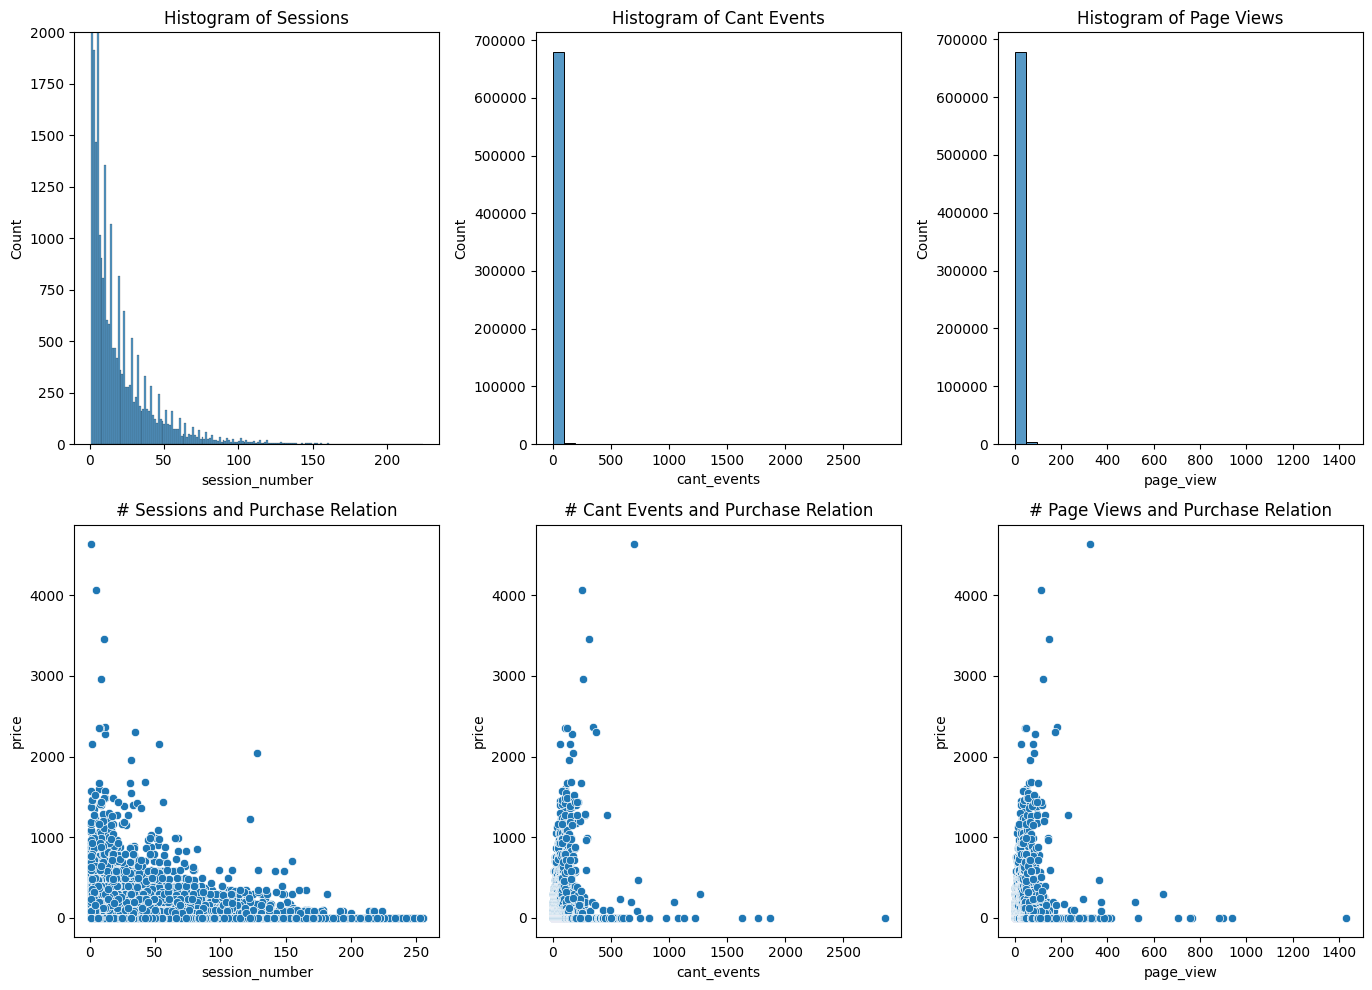

In [18]:
# Set up the figure with 2 rows and 3 columns of subplots
fig = plt.figure(figsize=(14, 10))

# Graph 1: Histogram of session_number for prices > 0
ax1 = fig.add_subplot(2, 3, 1)
sns.histplot(df[df['price'] > 0], x='session_number', ax=ax1)
ax1.set_title('Histogram of Sessions')
ax1.set_ylim([0, 2000])

# Graph 2: Histogram of cant_events with more bins
ax2 = fig.add_subplot(2, 3, 2)
sns.histplot(df, x='cant_events', ax=ax2, bins=30)
ax2.set_title('Histogram of Cant Events')

# Graph 3: Histogram of page_view with more bins
ax3 = fig.add_subplot(2, 3, 3)
sns.histplot(df, x='page_view', ax=ax3, bins=30)
ax3.set_title('Histogram of Page Views')

# Graph 4: Scatter plot of session_number vs. price
ax4 = fig.add_subplot(2, 3, 4)
sns.scatterplot(data=df, x='session_number', y='price', ax=ax4)
ax4.set_title('# Sessions and Purchase Relation')

# Graph 5: Scatter plot of cant_events vs. price
ax5 = fig.add_subplot(2, 3, 5)
sns.scatterplot(data=df, x='cant_events', y='price', ax=ax5)
ax5.set_title('# Cant Events and Purchase Relation')

# Graph 6: Scatter plot of page_view vs. price
ax6 = fig.add_subplot(2, 3, 6)
sns.scatterplot(data=df, x='page_view', y='price', ax=ax6)
ax6.set_title('# Page Views and Purchase Relation')

# Adjust layout
plt.tight_layout()
plt.show()

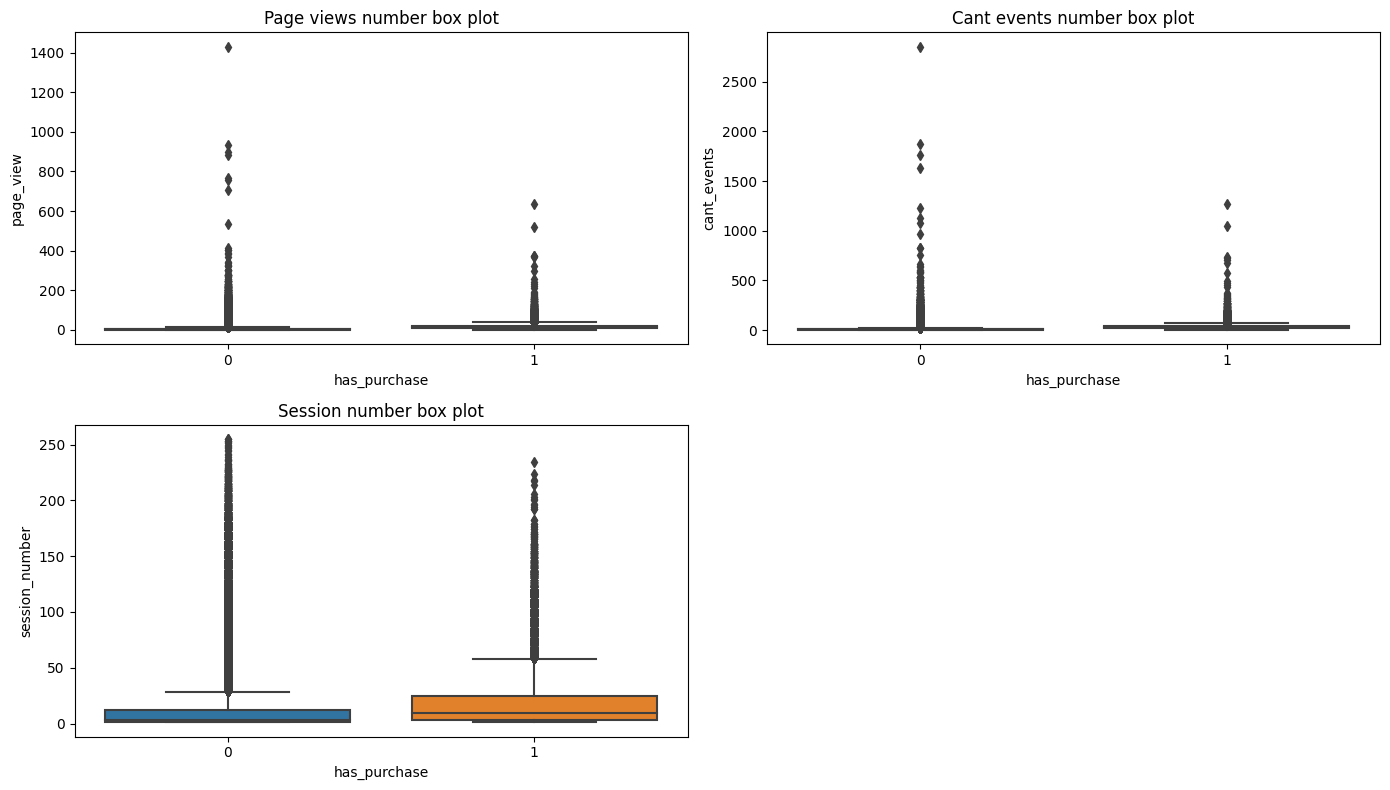

In [19]:
# Set up the figure (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Graph 1: Box plot for page views number
sns.boxplot(data=df, x='has_purchase', y='page_view', ax=axs[0, 0])
axs[0, 0].set_title('Page views number box plot')

# Graph 2: Box plot for cant events number
sns.boxplot(data=df, x='has_purchase', y='cant_events', ax=axs[0, 1])
axs[0, 1].set_title('Cant events number box plot')

# Graph 3: Box plot for session number
sns.boxplot(data=df, x='has_purchase', y='session_number', ax=axs[1, 0])
axs[1, 0].set_title('Session number box plot')

# Remove empty subplot (bottom-right)
fig.delaxes(axs[1, 1])

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

# 4. Handling outliers

In [20]:
# Define first and third quartile
q1, q2, q3 = np.percentile(df['session_number'], [25, 50, 75])

# Define interquartile range
IQR = q3 - q1

#defining max and min limits
max_limit = q3 + (5 * IQR)
min_limit = q1 - (5 * IQR)
idx_drop_outliers = df[((df['session_number'] < min_limit) | (df['session_number'] > max_limit)) ].index
df = df.drop(idx_drop_outliers)

In [21]:
# Define first and third quartile
q1, q2, q3 = np.percentile(df['page_view'], [25, 50, 75])

# Define interquartile range
IQR = q3 - q1

#defining max and min limits
max_limit = q3 + (5 * IQR)
min_limit = q1 - (5 * IQR)
idx_drop_outliers = df[((df['page_view'] < min_limit) | (df['page_view'] > max_limit)) ].index
df = df.drop(idx_drop_outliers)

In [22]:
# Define first and third quartile
q1, q2, q3 = np.percentile(df['cant_events'], [25, 50, 75])

# Define interquartile range
IQR = q3 - q1

#defining max and min limits
max_limit = q3 + (8 * IQR)
min_limit = q1 - (8 * IQR)
idx_drop_outliers = df[((df['cant_events'] < min_limit) | (df['cant_events'] > max_limit)) ].index
df = df.drop(idx_drop_outliers)

## Histogram without outliers

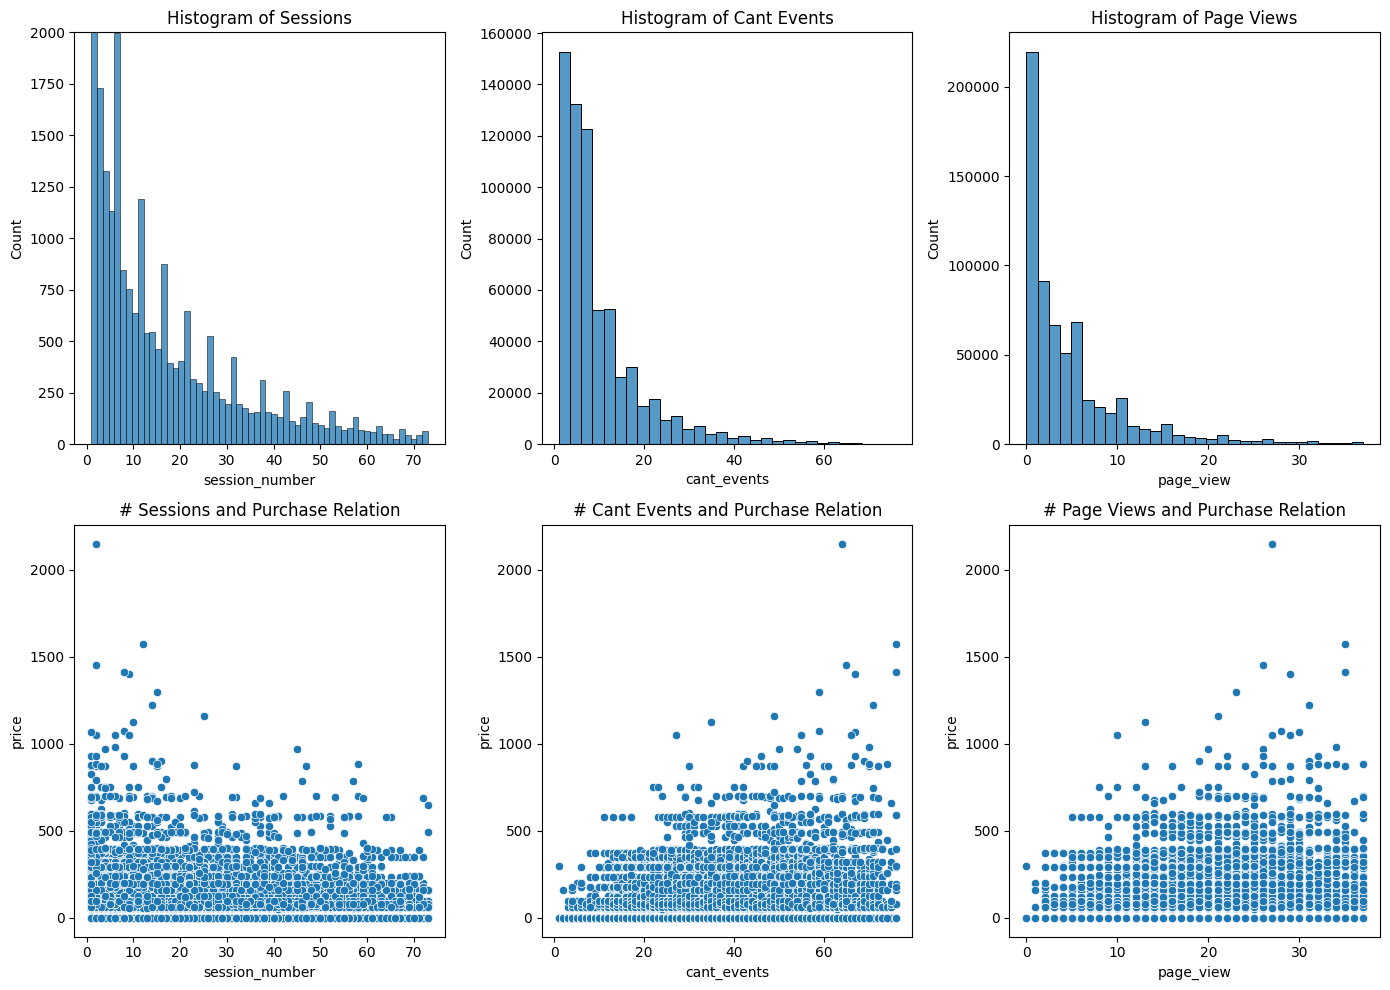

In [23]:
# Set up the figure with 2 rows and 3 columns of subplots
fig = plt.figure(figsize=(14, 10))

# Graph 1: Histogram of session_number for prices > 0
ax1 = fig.add_subplot(2, 3, 1)
sns.histplot(df[df['price'] > 0], x='session_number', ax=ax1)
ax1.set_title('Histogram of Sessions')
ax1.set_ylim([0, 2000])

# Graph 2: Histogram of cant_events with more bins
ax2 = fig.add_subplot(2, 3, 2)
sns.histplot(df, x='cant_events', ax=ax2, bins=30)
ax2.set_title('Histogram of Cant Events')

# Graph 3: Histogram of page_view with more bins
ax3 = fig.add_subplot(2, 3, 3)
sns.histplot(df, x='page_view', ax=ax3, bins=30)
ax3.set_title('Histogram of Page Views')

# Graph 4: Scatter plot of session_number vs. price
ax4 = fig.add_subplot(2, 3, 4)
sns.scatterplot(data=df, x='session_number', y='price', ax=ax4)
ax4.set_title('# Sessions and Purchase Relation')

# Graph 5: Scatter plot of cant_events vs. price
ax5 = fig.add_subplot(2, 3, 5)
sns.scatterplot(data=df, x='cant_events', y='price', ax=ax5)
ax5.set_title('# Cant Events and Purchase Relation')

# Graph 6: Scatter plot of page_view vs. price
ax6 = fig.add_subplot(2, 3, 6)
sns.scatterplot(data=df, x='page_view', y='price', ax=ax6)
ax6.set_title('# Page Views and Purchase Relation')

# Adjust layout
plt.tight_layout()
plt.show()

## Box Plot without outliers

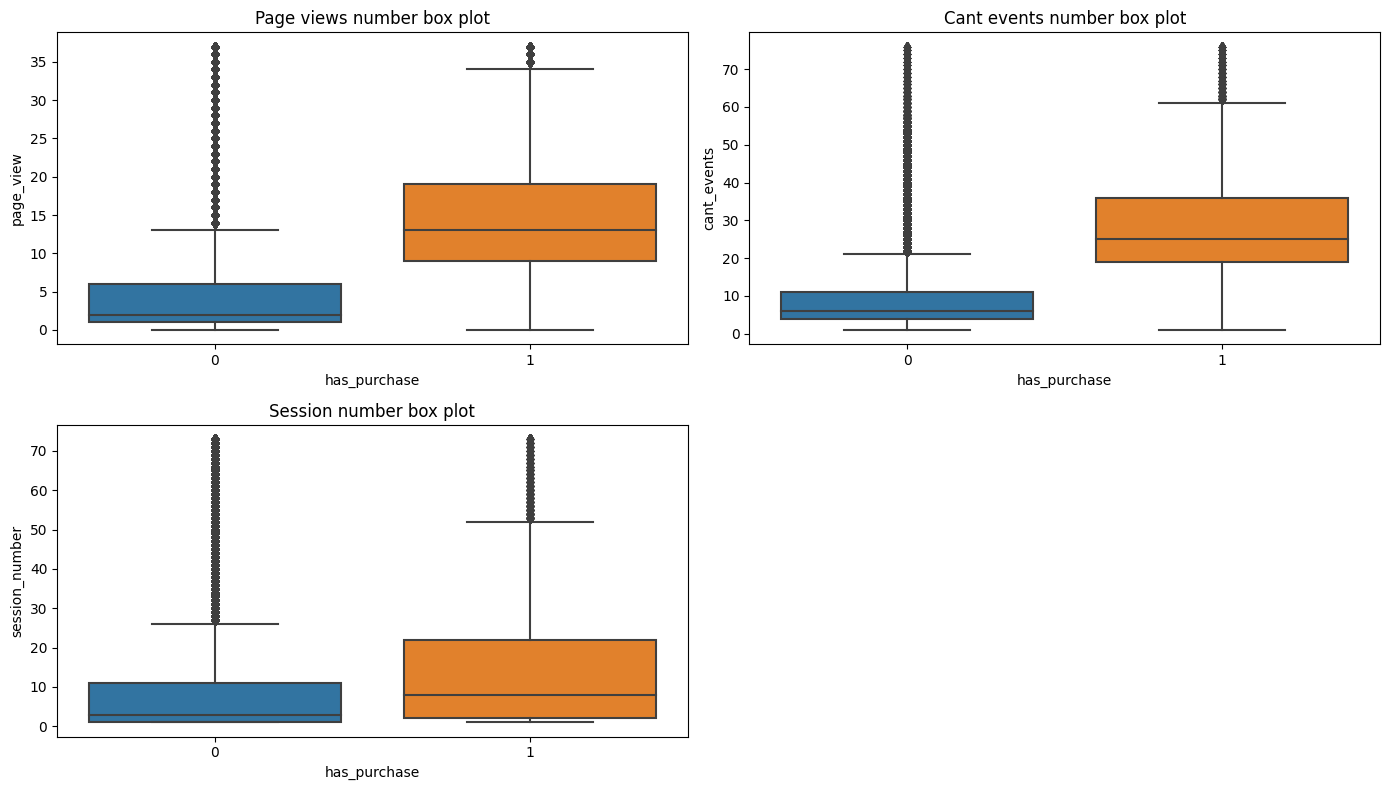

In [24]:
# Set up the figure (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# Graph 1: Box plot for page views number
sns.boxplot(data=df, x='has_purchase', y='page_view', ax=axs[0, 0])
axs[0, 0].set_title('Page views number box plot')

# Graph 2: Box plot for cant events number
sns.boxplot(data=df, x='has_purchase', y='cant_events', ax=axs[0, 1])
axs[0, 1].set_title('Cant events number box plot')

# Graph 3: Box plot for session number
sns.boxplot(data=df, x='has_purchase', y='session_number', ax=axs[1, 0])
axs[1, 0].set_title('Session number box plot')

# Remove empty subplot (bottom-right)
fig.delaxes(axs[1, 1])

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

# 4. Featuring Engineering

## Creating new features

## 1. Session duration

In [25]:
#Add new columns session_duration
df['session_duration_min'] = (df['visitSEndTime'] - df['visitStartTime']).dt.total_seconds() / 60

## 2. Day name

In [26]:
#Add day name column, it's done to know if an special day of the week could have an impact on sales
df['day_name'] = df['visitStartTime'].dt.day_name()

## 3. Unique visit

In [27]:
# First, group by 'user_id' and calculate the number of occurrences for each user
df['user_count'] = df.groupby('user_id')['user_id'].transform('count')

# Now create the 'unique_visit' column based on the condition
df['unique_visit'] = df.apply(lambda x: 1 if x['user_count'] == 1 or x['session_number'] == 1 else 0, axis=1)

# Drop the 'user_count' column if you no longer need it
df = df.drop(columns=['user_count'])

# 5. Relation among variables

## Unique_visit

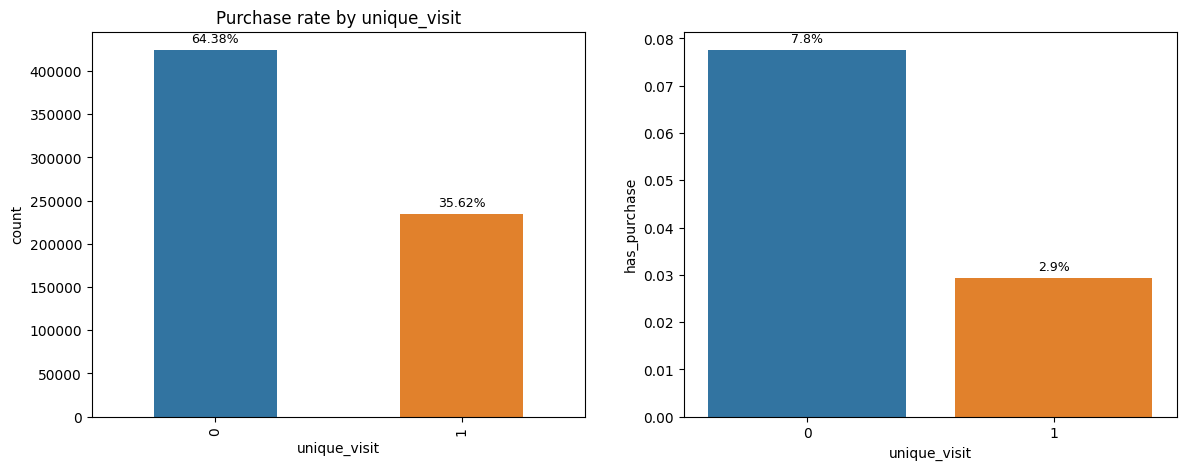

<Figure size 640x480 with 0 Axes>

In [28]:
fig = plt.figure(figsize = (14,5))

ax1 = fig.add_subplot(1,2,1)
sns.countplot(df, x = 'unique_visit', width = 0.5, ax = ax1)
ax1.set_title('Unique visite count')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)


# Add percentage labels on top of each bar in the second plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height / df.shape[0] * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=9, color='black', 
                xytext=(0, 8), textcoords='offset points')


ax2 = fig.add_subplot(1,2,2)
df_grouped = df.groupby('unique_visit')['has_purchase'].mean().reset_index()
sns.barplot(df_grouped, x = 'unique_visit', y= 'has_purchase', ax = ax2)
ax1.set_title('Purchase rate by unique_visit')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)

# Add percentage annotations
for p in ax2.patches:
    ax2.annotate(f'{p.get_height() * 100:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=9, color='black', xytext=(0, 8),
                 textcoords='offset points')

plt.show()
plt.tight_layout()

## Unique visit by operating_system

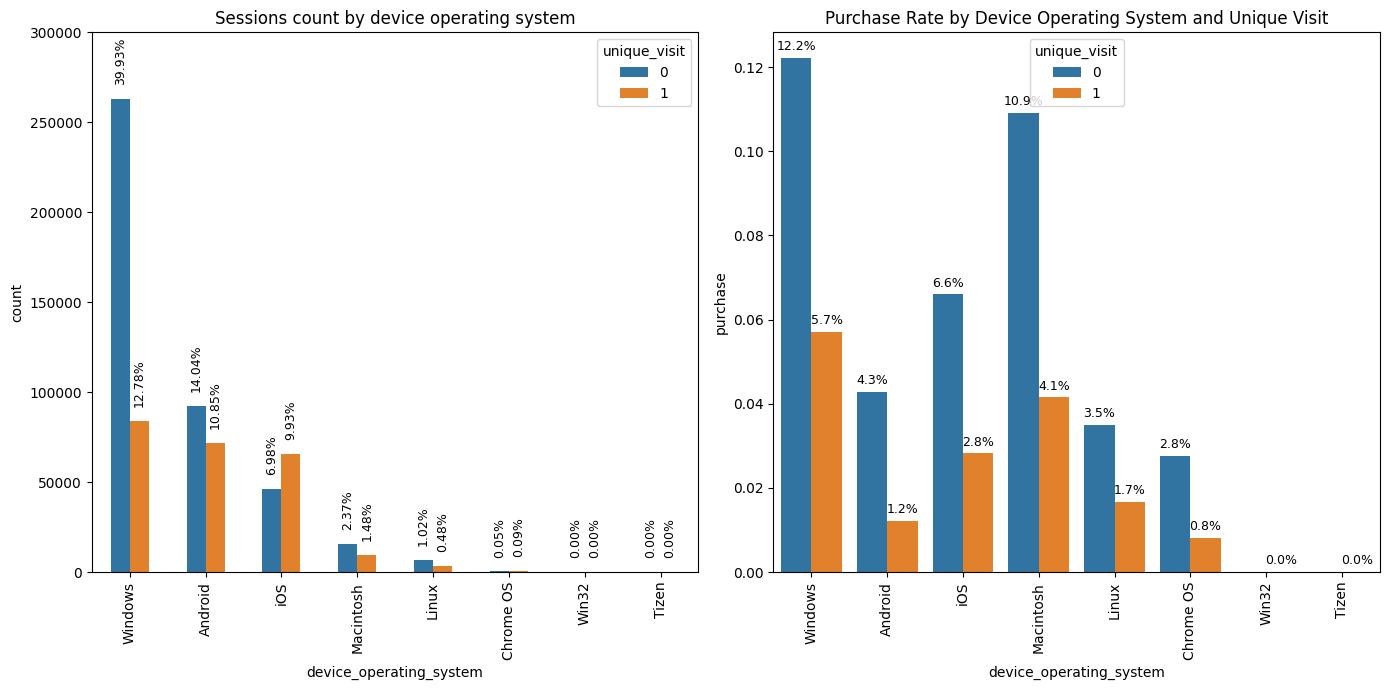

In [29]:
order_values = df['device_operating_system'].value_counts().index

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# First plot: countplot of device operating system, sorted by the same order as barplot
sns.countplot(df, x='device_operating_system', width=0.5, order=order_values, ax=ax1, hue='unique_visit')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Sessions count by device operating system')
ax1.set_ylim([0,300000])


# Add percentage labels on top of each bar in the second plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height / df.shape[0] * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black', rotation = 90,
                xytext=(0, 10), textcoords='offset points')

# Create a grouped dataset with purchase rate, including 'unique_visit' for hue
df_grouped = df.groupby(['device_operating_system', 'unique_visit'])['purchase'].mean().reset_index()

# Second plot: barplot with purchase rates, sorted by the same order
sns.barplot(data=df_grouped, x='device_operating_system', y='purchase', hue='unique_visit', order=order_values, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Purchase Rate by Device Operating System and Unique Visit')

# Add percentage labels on top of each bar in the second plot
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height * 100:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=9, color='black', 
                xytext=(0, 8), textcoords='offset points')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

## Unique visit by device_category

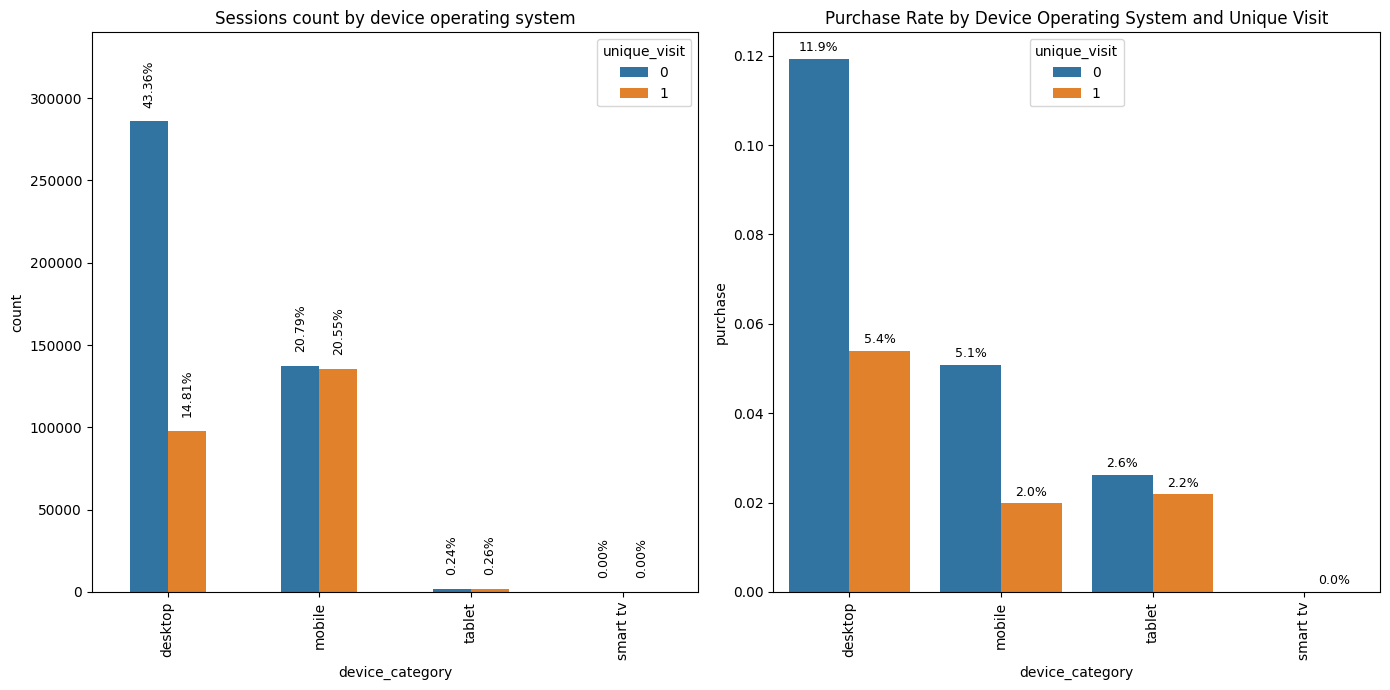

In [30]:
order_values = df['device_category'].value_counts().index

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# First plot: countplot of device operating system, sorted by the same order as barplot
sns.countplot(df, x='device_category', width=0.5, order=order_values, ax=ax1, hue='unique_visit')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Sessions count by device operating system')
ax1.set_ylim([0,340000])


# Add percentage labels on top of each bar in the second plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height / df.shape[0] * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black', rotation = 90,
                xytext=(0, 10), textcoords='offset points')

# Create a grouped dataset with purchase rate, including 'unique_visit' for hue
df_grouped = df.groupby(['device_category', 'unique_visit'])['purchase'].mean().reset_index()

# Second plot: barplot with purchase rates, sorted by the same order
sns.barplot(data=df_grouped, x='device_category', y='purchase', hue='unique_visit', order=order_values, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Purchase Rate by Device Operating System and Unique Visit')

# Add percentage labels on top of each bar in the second plot
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height * 100:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=9, color='black', 
                xytext=(0, 8), textcoords='offset points')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

## Unique visit by continent

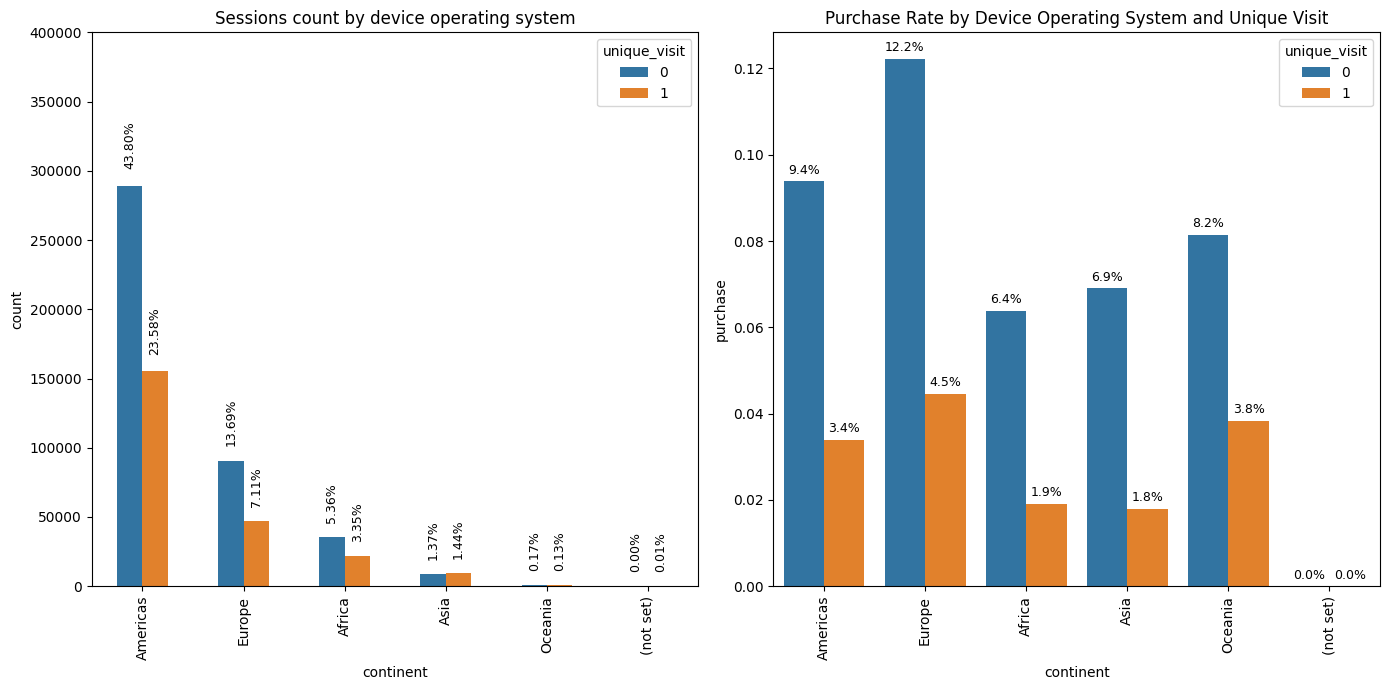

In [31]:
order_values = df['continent'].value_counts().index

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# First plot: countplot of device operating system, sorted by the same order as barplot
sns.countplot(df, x='continent', width=0.5, order=order_values, ax=ax1, hue='unique_visit')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Sessions count by device operating system')
ax1.set_ylim([0,400000])

# Add percentage labels on top of each bar in the second plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height / df.shape[0] * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., height*1.009),
                ha='center', va='bottom', fontsize=9, color='black', rotation = 90,
                xytext=(0, 10), textcoords='offset points')


# Create a grouped dataset with purchase rate, including 'unique_visit' for hue
df_grouped = df.groupby(['continent', 'unique_visit'])['purchase'].mean().reset_index()

# Second plot: barplot with purchase rates, sorted by the same order
sns.barplot(data=df_grouped, x='continent', y='purchase', hue='unique_visit', order=order_values, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Purchase Rate by Device Operating System and Unique Visit')

# Add percentage labels on top of each bar in the second plot
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height * 100:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=9, color='black', 
                xytext=(0, 8), textcoords='offset points')

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

## Unique visit by group_source_medium

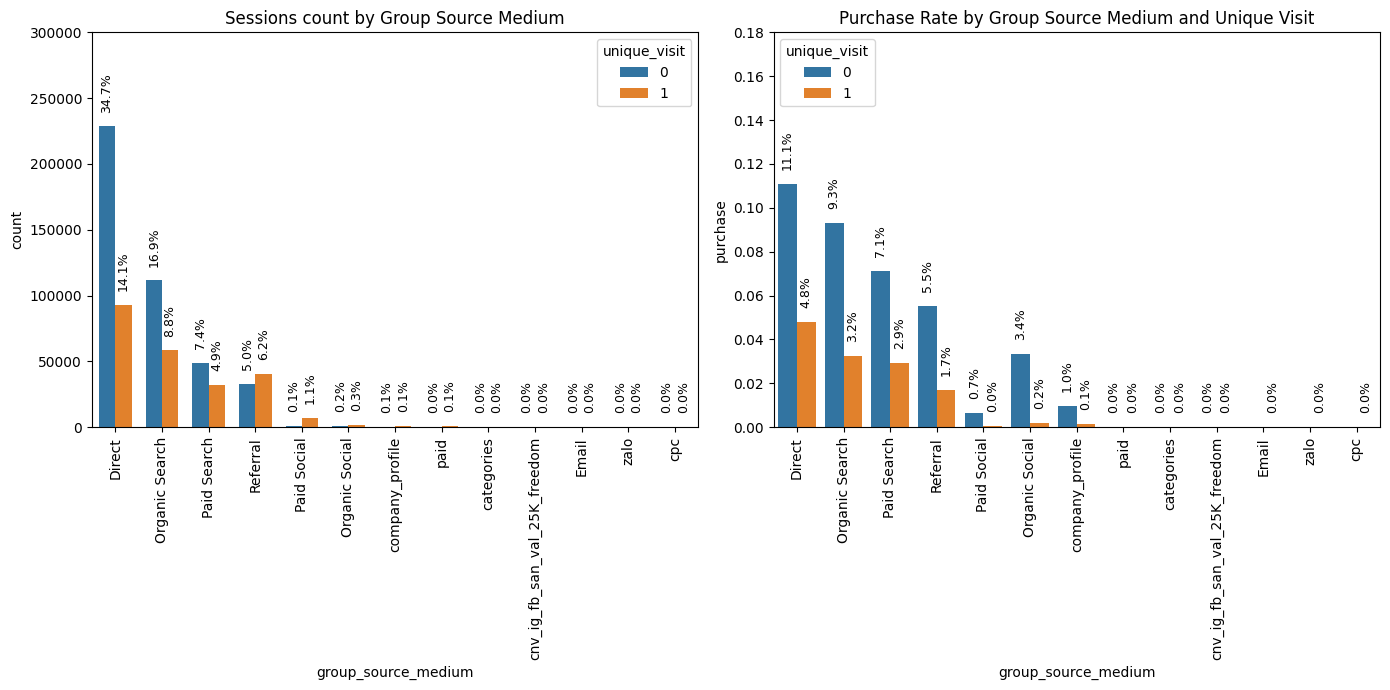

In [32]:
order_values = df['group_source_medium'].value_counts().index

# Set up the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# First plot: countplot of group_source_medium, sorted by the same order as barplot
sns.countplot(data=df, x='group_source_medium', width=0.7, order=order_values, ax=ax1, hue='unique_visit')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_title('Sessions count by Group Source Medium')
ax1.set_ylim([0,300000])

# Add percentage labels on top of each bar in the first plot
for p in ax1.patches:
    height = p.get_height()
    ax1.annotate(f'{height / df.shape[0] * 100:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black', rotation = 90,
                xytext=(0, 10), textcoords='offset points')  # Increase vertical offset

# Create a grouped dataset with purchase rate, including 'unique_visit' for hue
df_grouped = df.groupby(['group_source_medium', 'unique_visit'])['purchase'].mean().reset_index()

# Second plot: barplot with purchase rates, sorted by the same order
sns.barplot(data=df_grouped, x='group_source_medium', y='purchase', hue='unique_visit', order=order_values, ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_title('Purchase Rate by Group Source Medium and Unique Visit')
ax2.set_ylim([0,0.18])

# Add percentage labels on top of each bar in the second plot
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height * 100:.1f}%', 
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black', rotation = 90,
                xytext=(0, 10), textcoords='offset points')  # Increase vertical offset

# Adjust layout and show the figure
plt.tight_layout()
plt.show()

# 6. One hot encoding and normalization

In [33]:
#Separate categorical from numerical variables
numeric_var = df.select_dtypes(include = [np.number]).columns
categorical_var = df.select_dtypes(include = ['object']).columns
print(f'Numerical variables: {numeric_var}')
print(f'Categorical variables: {categorical_var}')

Numerical variables: Index(['session_number', 'cant_events', 'price', 'session_start', 'page_view',
       'user_engagement', 'scroll', 'login', 'click', 'begin_checkout',
       'add_payment_info', 'purchase', 'has_purchase', 'session_duration_min',
       'unique_visit'],
      dtype='object')
Categorical variables: Index(['user_id', 'device_operating_system', 'continent',
       'group_source_medium', 'device_category', 'day_name'],
      dtype='object')


In [34]:
#Create numeric and categorical df
df_num = df[numeric_var] 
df_cat = df[categorical_var]

In [35]:
# Drop columns
df_cat = df_cat.drop(columns = ['user_id'])
df_cat = pd.get_dummies(df_cat, drop_first=True).astype(int)

In [36]:
# Preserve the original indices of df
df = df.reset_index()  # Keep the original index as a column to track later
df_cat = df_cat.reset_index(drop=True)
df_num = df_num.reset_index(drop=True)

In [37]:
df_cat.head()

,device_operating_system_Chrome OS,device_operating_system_Linux,device_operating_system_Macintosh,device_operating_system_Tizen,device_operating_system_Win32,device_operating_system_Windows,device_operating_system_iOS,continent_Africa,continent_Americas,continent_Asia,...,group_source_medium_zalo,device_category_mobile,device_category_smart tv,device_category_tablet,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [38]:
#Normalization
from sklearn.preprocessing import RobustScaler

# Fill NaN values in 'session_duration_min' with 0
df_num.loc[:, 'session_duration_min'] = df_num['session_duration_min'].fillna(0)

# Create a normalizer object
scaler = RobustScaler()

# Fit and transform the data
normalized_array = scaler.fit_transform(df_num)

# Convert the normalized array back to a DataFrame
# Use the original column names
df_num = pd.DataFrame(normalized_array, columns=df_num.columns)

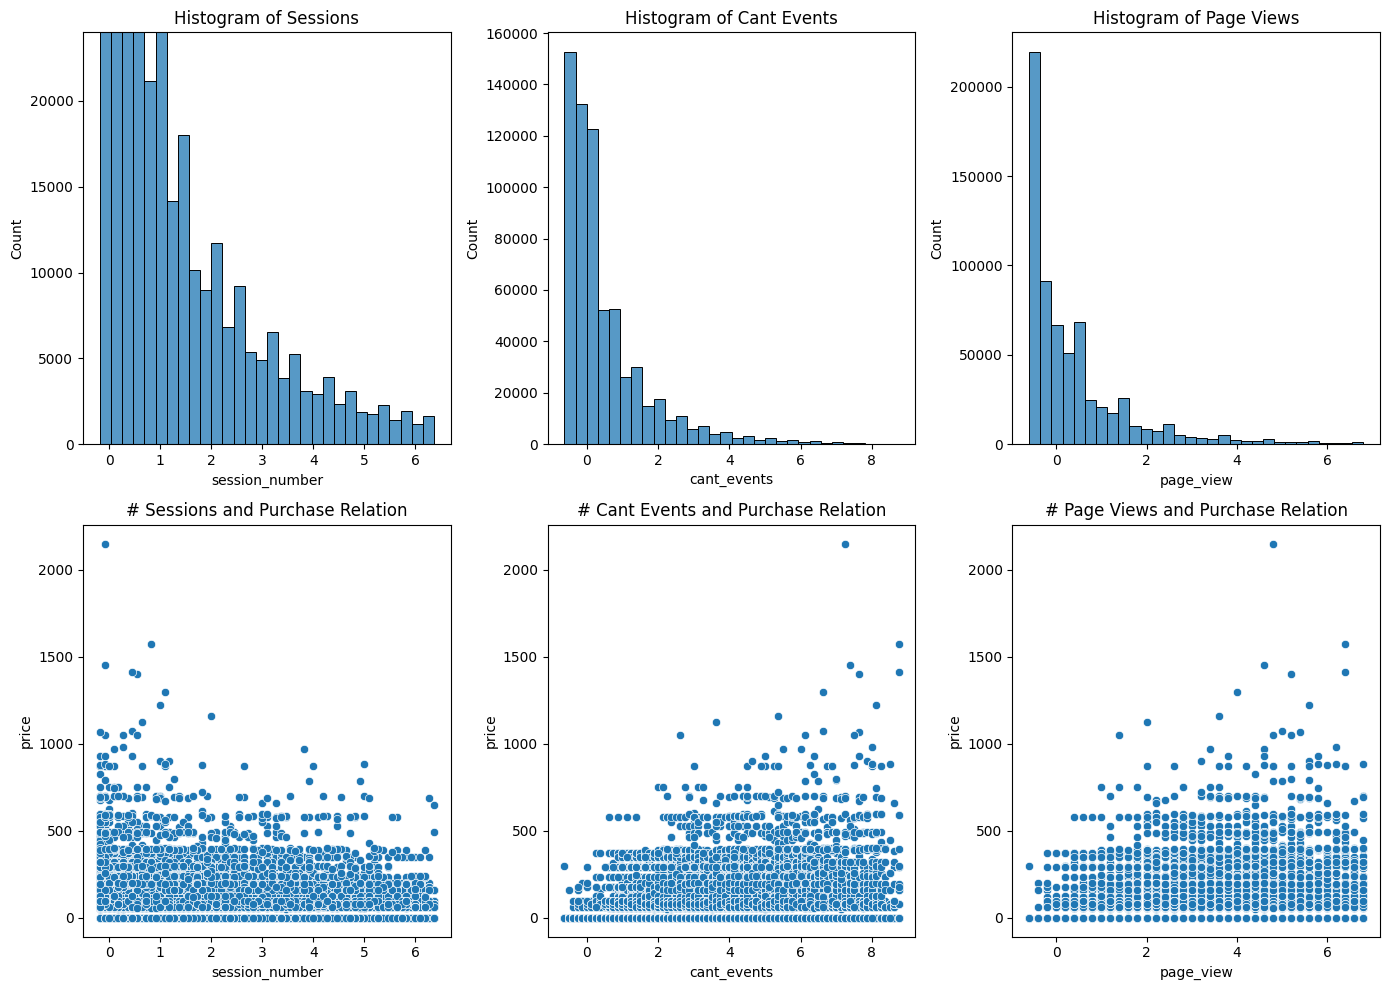

In [39]:
# Set up the figure with 2 rows and 3 columns of subplots
fig = plt.figure(figsize=(14, 10))

# Graph 1: Histogram of session_number for prices > 0
ax1 = fig.add_subplot(2, 3, 1)
sns.histplot(df_num, x='session_number', ax=ax1, bins = 30)
ax1.set_title('Histogram of Sessions')
ax1.set_ylim([0, 24000])

# Graph 2: Histogram of cant_events with more bins
ax2 = fig.add_subplot(2, 3, 2)
sns.histplot(df_num, x='cant_events', ax=ax2, bins=30)
ax2.set_title('Histogram of Cant Events')

# Graph 3: Histogram of page_view with more bins
ax3 = fig.add_subplot(2, 3, 3)
sns.histplot(df_num, x='page_view', ax=ax3, bins=30)
ax3.set_title('Histogram of Page Views')

# Graph 4: Scatter plot of session_number vs. price
ax4 = fig.add_subplot(2, 3, 4)
sns.scatterplot(data=df_num, x='session_number', y='price', ax=ax4)
ax4.set_title('# Sessions and Purchase Relation')

# Graph 5: Scatter plot of cant_events vs. price
ax5 = fig.add_subplot(2, 3, 5)
sns.scatterplot(data=df_num, x='cant_events', y='price', ax=ax5)
ax5.set_title('# Cant Events and Purchase Relation')

# Graph 6: Scatter plot of page_view vs. price
ax6 = fig.add_subplot(2, 3, 6)
sns.scatterplot(data=df_num, x='page_view', y='price', ax=ax6)
ax6.set_title('# Page Views and Purchase Relation')

# Adjust layout
plt.tight_layout()
plt.show()

In [40]:
all_data = pd.concat([df_cat, df_num], axis=1)

# 6. Modeling

In [41]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
seed = 42

In [42]:
#Define test and train datasets
# Assuming 'all_data' is your DataFrame and 'has_purchase' is your target column
X_train, X_test = train_test_split(all_data, test_size=0.3, random_state=seed)
y_train = X_train['has_purchase'].fillna(0)

##X_train = X_train.drop(columns = ['has_purchase'])

In [43]:
#Define validation dataset
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, train_size = 0.7)

In [44]:
%%time
## Declare grid parameter to tunning
param_grid = {'max_depth': [1, 3, 5],
             'reg_alpha': [0, 0.1, 1],
             'n_estimators': [50, 100, 150],
             'min_child_weight': [1, 3, 5],
             'learning_rate': [0.01, 0.05, 0.1],
             'colsample_bytree' : [0.6, 0.8, 1.0 ]
}

param_grid_small = {
    'max_depth': [3,5],
    'reg_alpha': [0, 0.1],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_child_weight': [1, 3],
}

xgb = XGBClassifier()
#cv_strat = StratifiedKFold(n_splits = 3, shuffle = True)
#grid_search = GridSearchCV(xgb, param_grid=param_grid_small, n_jobs=1, verbose=-1, cv=cv_strat, error_score='raise')
#grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

CPU times: user 161 µs, sys: 14 µs, total: 175 µs
Wall time: 180 µs


In [45]:
#print(grid_search.best_params_)

In [46]:
xgb_model = XGBClassifier(max_depth = 3,
                         reg_alpha= 0,
                         n_estimators = 50,
                         min_child_weight = 3,
                         learning_rate = 0.1 ,
                         colsample_bytree = 0.6)

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X_train.drop(columns = ['has_purchase']), X_train['has_purchase'], train_size = 0.7, random_state = seed)

In [48]:
#Number of folds
N = 3

#Creating a dataframe for storing the multiple folds' probability of one, in other words, probability of survival for predicting val set and test set
test_probs_of_one = pd.DataFrame(np.zeros((len(X_test), N)), columns= ['Fold_{}'.format(i) for i in range(1, N + 1)])


# create empty lists to store the predictions and scores for each fold
fold_train_scores = []
fold_val_scores = []

In [49]:
skf = StratifiedKFold(n_splits = N, shuffle = True)

In [50]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    if fold > 0:
        print('')
    print(f'We are working with the fold number: {fold+1}')    
    
    # select the train and validation data and labels for this fold
    fold_X_train, fold_y_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    fold_X_val, fold_y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # Fitting model using train and validation fold set
    xgb_model.fit(fold_X_train, fold_y_train, eval_set = [(fold_X_val, fold_y_val)], verbose = False)
    
    # Save the fold score with train data
    fold_score_training = xgb_model.score(X_train, y_train)
    print(fold_score_training)
    fold_train_scores.append(fold_score_training)
    print(f"Fold {fold + 1} train score: {fold_score_training}")
    
    fold_score_validation = xgb_model.score(X_val, y_val)
    print(fold_score_validation)
    fold_val_scores.append(fold_score_validation)
    print(f"Fold {fold + 1} validation score: {fold_score_validation}")
    
    # Now let's predict values on the test data
    test_probs_of_one.loc[:, 'Fold_{}'.format(fold+1)] = xgb_model.predict_proba(X_test.drop(columns=['has_purchase']))[:, 1]

# calculate the average accuracy score across all folds
avg_train_score = sum(fold_train_scores) / N 
avg_val_score = sum(fold_val_scores) / N 
    
print(f"\nAverage train score across {N} folds: {avg_train_score}")
print(f"Average val score across {N} folds: {avg_val_score}")

We are working with the fold number: 1
1.0
Fold 1 train score: 1.0
1.0
Fold 1 validation score: 1.0

We are working with the fold number: 2
1.0
Fold 2 train score: 1.0
1.0
Fold 2 validation score: 1.0

We are working with the fold number: 3
1.0
Fold 3 train score: 1.0
1.0
Fold 3 validation score: 1.0

Average train score across 3 folds: 1.0
Average val score across 3 folds: 1.0


In [51]:
test_probs_of_one.head()

,Fold_1,Fold_2,Fold_3
0,0.001018,0.001007,0.001013
1,0.001018,0.001007,0.001013
2,0.001018,0.001007,0.001013
3,0.993240,0.993216,0.993118
4,0.001169,0.001142,0.001110


In [52]:
#test_probs_of_one['avg_prob_of_one']=(test_probs_of_one.sum(axis=1)/N)
test_probs_of_one['avg_prob_of_one'] = test_probs_of_one[['Fold_1', 'Fold_2', 'Fold_3']].sum(axis=1)/N
test_probs_of_one[test_probs_of_one['avg_prob_of_one'] > 0.5].head().shape

(5, 4)

In [53]:
threshold= 0.5
test_probs_of_one['pred']= test_probs_of_one['avg_prob_of_one'].apply(lambda x: 1 if x>= threshold else 0)
test_probs_of_one.head()

,Fold_1,Fold_2,Fold_3,avg_prob_of_one,pred
0,0.001018,0.001007,0.001013,0.001012,0
1,0.001018,0.001007,0.001013,0.001012,0
2,0.001018,0.001007,0.001013,0.001012,0
3,0.993240,0.993216,0.993118,0.993191,1
4,0.001169,0.001142,0.001110,0.001140,0


In [54]:
test_probs_of_one['pred'].value_counts()

pred
0    185724
1     12049
Name: count, dtype: int64

In [55]:
df_check = test_probs_of_one[test_probs_of_one['pred'] == 1]
df_propensity = df.loc[df_check.index, :]

In [56]:
# Filter df where has_purchase == 1
df_filtered = df[df['has_purchase'] == 1]

# Get sets of user_id
user_ids_df_filtered = set(df_filtered['user_id'])
user_ids_propensity = set(df_propensity['user_id'])

# Find intersection
common_user_ids = user_ids_df_filtered.intersection(user_ids_propensity)
len(common_user_ids)

1155